In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import sys
import random

import matplotlib as mpl
from matplotlib import cm
from matplotlib import colors

PROJ_DIR = os.path.dirname(os.path.abspath('.'))
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

from utils.layout_utils import mean_IU, mean_precision

from networks.occant_baselines.depthsensor import DepthProjector
from configs import get_cfg_defaults

from multiprocessing import Pool

import pickle
from moviepy.video.io.bindings import mplfig_to_npimage


#Increase matplotlib font
plt.rcParams.update({'font.size': 14})

In [25]:
## MATPLOTLIB COLOR MAP

C_p = 11 # Classes

colour_names = [ # Your predefined colours
    "red",
    "green",
    "blue",
    "green",
    "yellow",
    "orange",
    "black",
    "purple",
    "turquoise",
    "grey",
    "maroon",
    "silver",
    "white"
]

colour_dict = { # Color mapping (class -> colour)
    i: mpl.colors.to_rgb(colour_names[i])
    for i in range(C_p + 1)
}

# Create a colormap (optional)
colours_rgb = [colour_dict[i] for i in range(C_p)]
colours = mpl.colors.ListedColormap(colours_rgb)

norm = mpl.colors.BoundaryNorm(np.arange(C_p + 1) - 0.5, C_p)

In [26]:
data_dir = '/scratch/shantanu/gibson4/new'
scenes = os.listdir(data_dir)
scenes[:5]

['Sisters', 'Shelbiana', 'Azusa', 'Nuevo', 'Crandon']

In [27]:
camera_pose = ['front']

process_args = [(scene, pose, filename) for scene in scenes \
                for pose in camera_pose \
                for filename in os.listdir(os.path.join(data_dir, scene, '0', pose, 'DEPTH'))]

print(len(process_args))
print(process_args[0])

23025
('Sisters', 'front', '52.png')


In [28]:
dp = None # Depth Projector

In [29]:
def initialize():
    global dp
    
    cfg = get_cfg_defaults()
    cfg.merge_from_file('../configs/train_occant_gibson4.yaml')
    cfg.width = 512
    cfg.height = 512
    
    cfg.freeze()
    dp = DepthProjector(cfg)
    
    dp.offset_camera_plane = False
    dp.offset_baseline = False

In [30]:
def get_vo_map(args):
    scene, pose, filename = args
    depth = cv2.imread(os.path.join(data_dir, scene, '0', pose, 'DEPTH', filename), -1)/6553.5
    depth = cv2.resize(depth, (dp.config.width, dp.config.height))
    vo_map = dp.get_depth_projection(depth)
    
    # Convert from 2-channel(explored, occ) to 3-value 1ch (unknown, occ, free) map
    vo_map = vo_map.reshape((-1, 2))
    ego_map_gt = np.zeros((dp.config.bev_height * dp.config.bev_width), dtype=np.uint8)
    ego_map_gt[vo_map[:, 0]] = 0
    ego_map_gt[np.logical_and(vo_map[:, 0] == 1, vo_map[:, 1] == 1)] = 127  # occupied
    ego_map_gt[np.logical_and(vo_map[:, 0] == 0, vo_map[:, 1] == 1)] = 254  # explored
    ego_map_gt = ego_map_gt.reshape((dp.config.bev_height, dp.config.bev_width))
    
    output_path = os.path.join(out_dir, scene, '0', pose, 'vo', filename)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, ego_map_gt)

In [31]:
out_dir = '/scratch/shantanu/gibson4/visible_occupancy'

os.makedirs(out_dir, exist_ok=True)

with Pool(processes=10, initializer=initialize) as p:
    p.map(get_vo_map, process_args)

## Quantitative Comparison

In [9]:
data_dir = '/scratch/shantanu/gibson4/new'
partial_occ_dir = '/scratch/shantanu/gibson4/dilated_partialmaps'
vo_dir = '/scratch/shantanu/gibson4/visible_occupancy'
ck_dir = '/scratch/shantanu/gibson4/chandrakar_g4'
sem_dir = '/scratch/shantanu/gibson4/semantics'

In [10]:
with open('../splits/gibson4/filtered_front_train_files.txt', 'r') as f:
    fps = f.read().splitlines()
    
print(fps[:4])

['Pettigrew front 0', 'Pettigrew front 1', 'Pettigrew front 2', 'Pettigrew front 3']


In [11]:
filenames = {}
IOU = {}  # scene->file_scores
AP = {}

for fp in fps:
    scene, pose, fileidx = fp.split()
    if scene not in IOU:
        IOU[scene] = []
        AP[scene] = []
        filenames[scene] = []
        
    filenames[scene].append(fileidx)
    
    po_map = cv2.imread(os.path.join(partial_occ_dir, scene, pose, 'partial_occ', f'{fileidx}.png'), -1)
    po_map = po_map[64:, 32:96] // 127
    
    vo_map = cv2.imread(os.path.join(vo_dir, scene, '0', pose, 'vo', f'{fileidx}.png'), -1)
    vo_map = cv2.resize(vo_map, (64, 64), interpolation=cv2.INTER_NEAREST) // 127
    
    ck_map = cv2.imread(os.path.join(ck_dir, scene, '0', pose, 'pred_bev', f'{fileidx}.png'), -1)
    ck_map = ck_map // 127
    
    # Crop bottom 20-pixels (0.05*20 = 1 meter for 90fov)
    po_map = po_map[:-20, :]
    vo_map = vo_map[:-20, :]
    ck_map = ck_map[:-20, :]
    
    # IOU
    scores = []  # [vo_po, ck_po, ck_vo]
    scores.append(mean_IU(vo_map, po_map, 3))
    scores.append(mean_IU(ck_map, po_map, 3))
    scores.append(mean_IU(ck_map, vo_map, 3))
    
    IOU[scene].append(scores)
    
    # AP
    scores = []  # [vo_po, ck_po, ck_vo]
    scores.append(mean_precision(vo_map, po_map, 3))
    scores.append(mean_precision(ck_map, po_map, 3))
    scores.append(mean_precision(ck_map, vo_map, 3))
    
    AP[scene].append(scores)

In [14]:
# pickle.dump(IOU, open('../info/gibson4_crop20_iou.npy', 'wb'))
# pickle.dump(AP, open('../info/gibson4_crop20_p.npy', 'wb'))
# pickle.dump(filenames, open('../info/gibson4_crop20_filenames.pkl', 'wb'))

# IOU = pickle.load(open('../info/gibson4_crop20_iou.npy', 'rb'))
# AP = pickle.load(open('../info/gibson4_crop20_ap.npy', 'rb'))
# filenames = pickle.load(open('../info/gibson4_crop20_filenames.pkl', 'rb'))

In [15]:
all_scores = np.empty((0, 3, 3))
for scene in IOU:
    all_scores = np.concatenate([all_scores, IOU[scene]], axis=0)
    
print('shape', all_scores.shape, '\n')
    
print('IOU mean')
print(all_scores.mean(axis=0), '\n')

print('IOU std')
print(all_scores.std(axis=0))

shape (18436, 3, 3) 

IOU mean
[[0.61196328 0.4535674  0.54043935]
 [0.53329105 0.         0.53687008]
 [0.7495473  0.         0.59672102]] 

IOU std
[[0.28137535 0.18164907 0.26373791]
 [0.28592223 0.         0.26120384]
 [0.20901488 0.         0.26592182]]


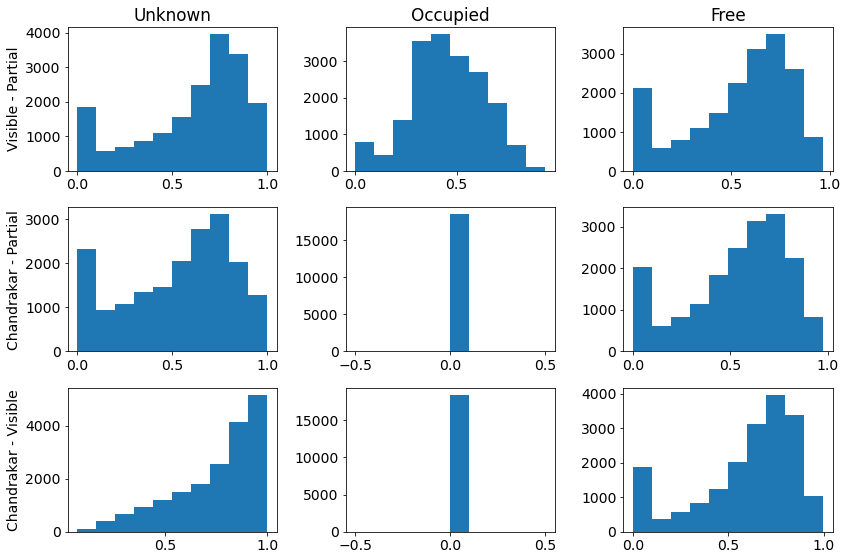

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12, 8))

for idx in range(3):
    ax[idx][0].hist(all_scores[:, idx, 0])
    ax[idx][1].hist(all_scores[:, idx, 1])
    ax[idx][2].hist(all_scores[:, idx, 2])
    
ax[0][0].set_ylabel('Visible - Partial')
ax[1][0].set_ylabel('Chandrakar - Partial')
ax[2][0].set_ylabel('Chandrakar - Visible')

ax[0][0].set_title('Unknown')
ax[0][1].set_title('Occupied')
ax[0][2].set_title('Free')

plt.tight_layout()
plt.show()

In [17]:
print("Scene   VO_PO    CK_PO    CK_VO")
with np.printoptions(precision=2, suppress=True):
    for scene in IOU:
        print(scene, *(np.array(IOU[scene]) * 100).mean(axis=0))

Scene   VO_PO    CK_PO    CK_VO
Pettigrew [59.86 51.73 62.93] [50.98  0.   58.66] [71.99  0.   63.15]
Hambleton [68.98 47.79 45.63] [61.06  0.   46.34] [80.73  0.   55.66]
Angiola [54.19 54.28 61.32] [42.44  0.   45.98] [65.67  0.   54.35]
Stilwell [68.64 39.43 60.41] [62.35  0.   61.84] [83.83  0.   68.26]
Rosser [68.2  56.05 30.9 ] [56.54  0.   30.83] [71.6   0.   36.56]
Shelbiana [72.56 37.13 52.05] [66.89  0.   52.38] [86.04  0.   61.93]
Capistrano [60.53 47.84 50.7 ] [51.74  0.   51.7 ] [73.08  0.   55.58]
Hometown [60.78 50.21 52.81] [51.36  0.   53.67] [70.44  0.   61.32]
Roxboro [65.38 34.45 54.45] [59.25  0.   60.24] [82.1   0.   63.69]
Dunmor [61.88 47.87 53.74] [52.72  0.   48.11] [74.99  0.   58.16]
Avonia [66.84 37.6  62.43] [62.11  0.   63.73] [84.69  0.   71.61]
Arkansaw [62.95 48.76 47.85] [52.21  0.   48.1 ] [71.15  0.   56.45]
Sanctuary [46.82 44.69 52.89] [39.16  0.   57.85] [64.63  0.   58.47]
Bolton [66.6  46.09 51.84] [57.98  0.   48.95] [77.83  0.   57.  ]
Sumas 

In [18]:
low_iou_files = {}
scenes = list(filenames.keys())

for scene in scenes:
    scene_iou = []
    for idx, filename in enumerate(filenames[scene]):
        iu = IOU[scene][idx][0]  # vo_po
        if (iu[2] < 0.1) or (iu[1] < 0.1):
            scene_iou.append((idx, filename, iu))
    scene_iou = sorted(scene_iou, key=lambda x: x[2][2])
    low_iou_files[scene] = scene_iou
            
sum([len(x) for x in low_iou_files.values()]) / sum([len(filenames[x]) for x in filenames])

0.13500759383814276

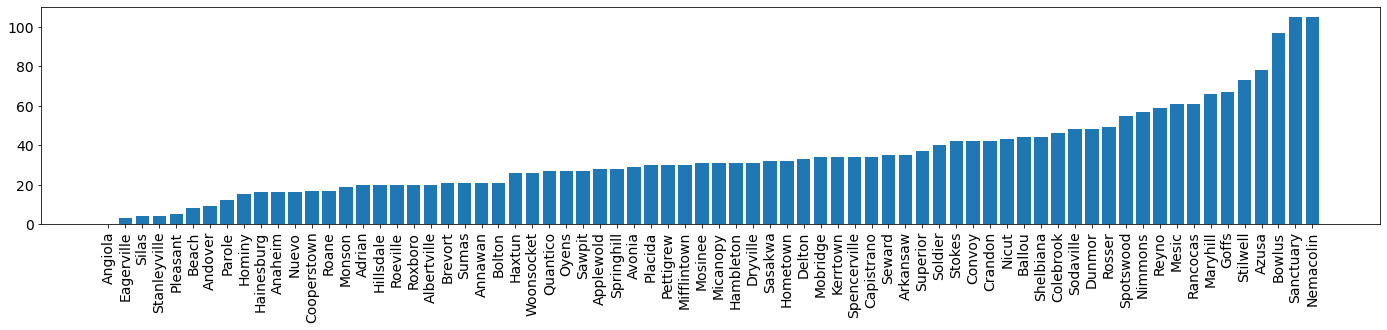

In [19]:
fig = plt.figure(figsize=(24, 4))

scenes = np.array(scenes)
counts = np.array([len(x) for x in low_iou_files.values()])

idx = np.argsort(counts)
scenes = scenes[idx]
counts = counts[idx]

plt.bar(scenes, counts)
plt.xticks(rotation=90)
plt.show()

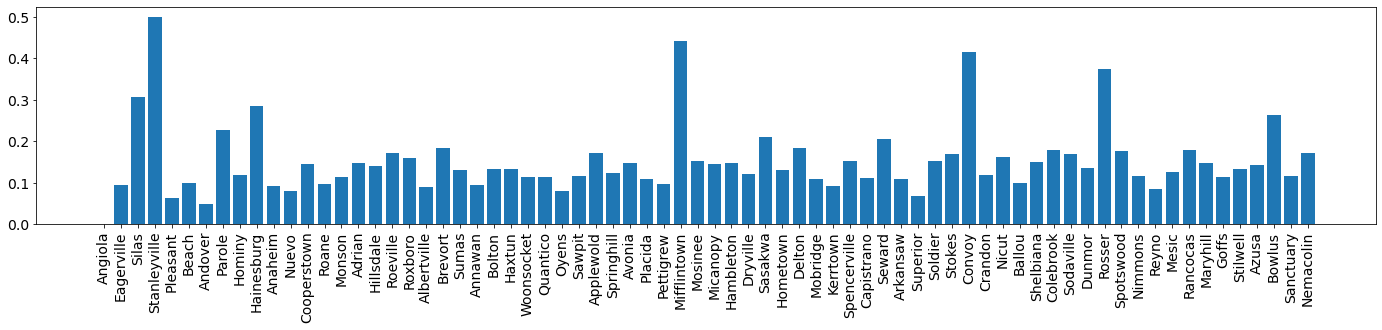

In [20]:
totals = np.zeros(len(scenes))
for fp in fps:
    scene, pose, fileidx = fp.split()
    idx = np.where(scenes == scene)[0].item()
    totals[idx] += 1
    
pct = counts/totals
    
fig = plt.figure(figsize=(24, 4))
plt.bar(scenes, pct)
plt.xticks(rotation=90)
plt.show()

In [21]:
def get_seg_map(depth, bev, K):
    inv_K = np.linalg.inv(K[:3,:3])

    h, w = depth.shape

    img_rect = np.concatenate([np.indices((w, h)), np.ones((1, w, h))], axis=0)

    pc = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
    pc = pc.transpose((0,2,1)) * depth
    pc = pc.reshape((3, -1))

    pc = np.concatenate([pc, np.ones((1, h*w))], axis=0)

    bev_size = (3.2, 3.2) # m
    bev_res = bev_size[0] / bev.shape[0]

    T = np.zeros((4, 4))
    T[0,0] = 1
    T[1,2] = -1
    T[2,1] = 1
    T[3,3] = 1
    T[0,3] = 1.6
    T[1,3] = 3.2

    ortho_cam_points = (T @ pc) // bev_res
    valid = (ortho_cam_points[0] >= 0) & (ortho_cam_points[0] < bev.shape[1]) & (ortho_cam_points[1] >= 0) & (ortho_cam_points[1] < bev.shape[0]) & (ortho_cam_points[2] >= 0)

    pt_bev_indices = (ortho_cam_points[1, valid]*bev.shape[1] + ortho_cam_points[0, valid]).astype(int)
    pt_bev_cls = np.take(bev.reshape(-1), pt_bev_indices)

    seg_map = np.zeros(w * h, dtype=np.uint8)
    seg_map[valid] = pt_bev_cls
    seg_map = seg_map.reshape((h, w))
    
    return seg_map

In [22]:
def get_bev_diff_plot(scene, fileidx, iu):
    for axis in ax:
        axis.clear()
            
    rgb = cv2.imread(os.path.join(data_dir, scene,'0', pose, 'RGB', f'{fileidx}.jpg'), -1)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

    depth = cv2.imread(os.path.join(data_dir, scene,'0', pose, 'DEPTH', f'{fileidx}.png'), -1) / 6553.5

    sem = cv2.imread(os.path.join(sem_dir, scene,'0', pose, 'semantics', f'{fileidx}.png'), -1)
    floor_seg = np.isin(sem, [3, 28]) * 1.0 + 1
    floor_seg[0, 0] = 0

    po_map = cv2.imread(os.path.join(partial_occ_dir, scene, pose, 'partial_occ', f'{fileidx}.png'), -1)
    po_map = po_map[64:, 32:96] // 127

    vo_map = cv2.imread(os.path.join(vo_dir, scene, '0', pose, 'vo', f'{fileidx}.png'), -1)
    vo_map = cv2.resize(vo_map, (64, 64), interpolation=cv2.INTER_NEAREST) // 127

    ck_map = cv2.imread(os.path.join(ck_dir, scene, '0', pose, 'pred_bev', f'{fileidx}.png'), -1)
    ck_map = ck_map // 127

    bev_comparison = np.zeros((*po_map.shape, 3), dtype=np.uint8)
    bev_comparison[np.logical_and(po_map==0, vo_map!=0), 0] = 255
    bev_comparison[np.logical_and(po_map==1, vo_map!=1), 1] = 255
    bev_comparison[np.logical_and(po_map==2, vo_map!=2), 2] = 255

    K = np.eye(4)
    K[0, 0] = K[1, 1] = 512
    K[0, 2] = K[1, 2] = 512

    po_seg_map = get_seg_map(depth, po_map, K)
    vo_seg_map = get_seg_map(depth, vo_map, K)

    sem_overlay = np.copy(rgb) // 2
    sem_overlay[np.logical_and(po_seg_map==0, vo_seg_map!=0), 0] *= 3
    sem_overlay[np.logical_and(po_seg_map==1, vo_seg_map!=1), 1] *= 3
    sem_overlay[np.logical_and(po_seg_map==2, vo_seg_map!=2), 2] *= 3

    ax[0].imshow(rgb)
    ax[1].imshow(po_map, cmap = colours, norm=norm)
    ax[2].imshow(vo_map, cmap = colours, norm=norm)
    ax[3].imshow(bev_comparison)
    ax[4].imshow(sem_overlay)
    
    ax[2].set_title('IOU: {:.02f} {:.02f} {:.02f}'.format(*iu), fontsize= 30)
    
    fig.canvas.draw()

    return mplfig_to_npimage(fig)

In [23]:
out_dir = '/scratch/shantanu/po_vo_comparison/free0.1_occ0.1'
fig = ax = None

def initialize():
    global fig, ax
    fig, ax = plt.subplots(ncols=5, figsize=(20, 4))

def write_bev_comparison_plot(arg):
    scene, filename, iu = arg
    output_path = os.path.join(out_dir, scene, f'{filename}.png')
    img = cv2.cvtColor(get_bev_diff_plot(scene, filename, iu), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, img)

process_args = [(scene, filename, iu) for scene, row in low_iou_files.items() for (_, filename, iu) in row]
print(len(process_args))

for scene in low_iou_files.keys():
    os.makedirs(os.path.join(out_dir, scene), exist_ok=True)
    
with Pool(processes=10, initializer=initialize) as pool:
    pool.map(write_bev_comparison_plot, process_args)

2489


## Depth analysis for normalizing input

In [6]:
depths = np.zeros((len(fps), 512, 512), dtype=np.float32)

for idx, fp in enumerate(fps):
    scene, pose, fileidx = fp.split()
    
    depth = cv2.imread(os.path.join(data_dir, scene, '0', pose, 'DEPTH', f'{fileidx}.png'), -1)
    depth = cv2.resize(depth, (512, 512))/6553.5
    
    depths[idx] = depth

In [36]:
np.mean(depths), np.std(depths)

(1.678333, 1.147846)

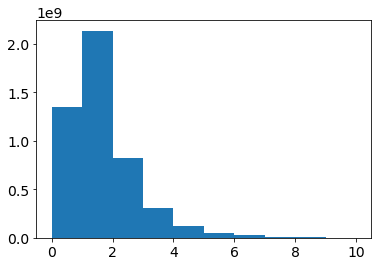

In [38]:
plt.hist(depths.reshape(-1))
plt.show()

In [39]:
(10 - 1.67)/1.147

7.2624237140366175

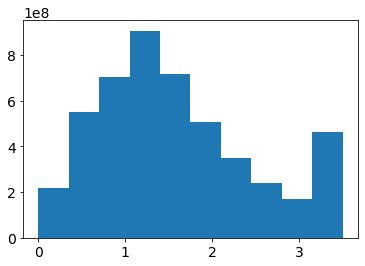

In [40]:
clipped_depth = np.clip(depths, a_min=0, a_max=3.5)
plt.hist(clipped_depth.reshape(-1))
plt.show()

In [ ]:
log_depth = np.log(depths)
plt.hist(log_depth.reshape(-1))
plt.show()

In [7]:
np.percentile(depths.reshape(-1), [0, 1, 5, 10, 90, 95, 99, 100])

array([0.        , 0.1762417 , 0.3695735 , 0.53498131, 3.10612655,
       3.89868021, 5.8612957 , 9.99954224])

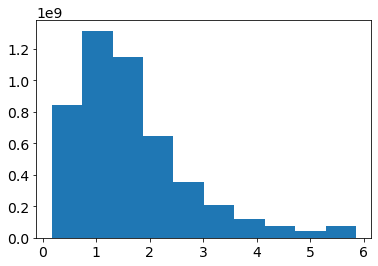

In [8]:
clipped_depth = np.clip(depths, a_min=0.17, a_max=5.86)
plt.hist(clipped_depth.reshape(-1))
plt.show()